In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Lectura del csv generado por scraping, con encabezados en la primera columna
file_path = '/content/drive/My Drive/UNI/Analitica_de_datos/Trabajos/Datos_Arduino.csv'
df = pd.read_csv(file_path)

# Imprime las primeras 5 filas del DataFrame
df.head()

,Hora,LdrValorAnalog,LdrVoltaje,LdrResistencia,Temperatura,Humedad
0,00:00:00,0.1,0.0005,2250380,17.8,83
1,00:00:05,0.1,0.0005,2250380,17.8,83
2,00:00:10,0.1,0.0005,2250380,17.8,83
3,00:00:15,0.1,0.0005,2250380,17.8,83
4,00:00:20,0.1,0.0005,2250380,17.8,83


### Descripción de variables
**Hora:** Esta variable registra el momento exacto en que se realiza cada medición, normalmente con un formato de hora como HH:MM:SS. Es fundamental para analizar la evolución temporal de las demás variables, permitiendo detectar patrones diarios o variaciones específicas en determinados intervalos del día. También es útil para sincronizar los datos si se combinan con otras fuentes.

**LdrValorAnalog:** Corresponde al valor bruto leído desde el sensor LDR (Light Dependent Resistor) mediante una entrada analógica del Arduino. Este valor suele oscilar entre 0 y 1023, ya que proviene de un conversor analógico-digital (ADC) de 10 bits. Cuanto mayor es la iluminación sobre el sensor, menor suele ser este valor, aunque esto puede depender de cómo está conectado el LDR en el circuito. Es una medida directa de la cantidad de luz presente en el entorno.

**LdrVoltaje:** Es el voltaje resultante de convertir el valor analógico anterior en unidades de voltaje real, generalmente mediante la fórmula
Voltaje = ValorAnalogico * ValorRef / 1023, donde ValorRef suele ser 5V o 3.3V. Esta conversión permite interpretar los datos del sensor de manera más estandarizada y compararlos con otros sistemas electrónicos

**LdrResistencia:** Representa la resistencia eléctrica estimada del sensor LDR en función del voltaje medido y una resistencia fija conocida en el circuito, comúnmente mediante un divisor de voltaje. A mayor iluminación, la resistencia del LDR disminuye. Este valor es útil cuando se desea entender de forma más detallada el comportamiento físico del sensor de luz y cómo responde ante distintas condiciones de luminosidad.

**Temperatura:** Esta variable muestra la temperatura ambiente en grados Celsius, medida con un sensor como el DHT11 o DHT22. Estos sensores digitales proporcionan una lectura bastante precisa para aplicaciones domésticas, educativas o experimentales. La temperatura puede influir en otras variables como la humedad relativa, por lo que su análisis conjunto permite obtener una mejor comprensión del entorno.

**Humedad:** Indica el porcentaje de humedad relativa en el aire, también recolectado con sensores como el DHT11 o DHT22. Es una medida esencial en aplicaciones de monitoreo ambiental, agricultura, domótica o control climático. Junto con la temperatura, permite calcular índices de confort térmico o identificar condiciones propicias para ciertos cultivos o procesos físicos.

In [4]:
#Dimensiones del dataset
print("Dimensiones del dataset:")
print(df.shape)

# Mostrar las columnas del dataset
print("Columnas del dataset:")
print(df.columns)

# Mostrar los valores nulos de cada columna
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Mostrar los tipos de datos de cada columna
print("\nTipos de datos por columna:")
print(df.dtypes)

Dimensiones del dataset:
(17280, 6)
Columnas del dataset:
Index(['Hora', 'LdrValorAnalog', 'LdrVoltaje', 'LdrResistencia', 'Temperatura',
       'Humedad'],
      dtype='object')

Valores nulos por columna:
Hora              0
LdrValorAnalog    0
LdrVoltaje        0
LdrResistencia    0
Temperatura       0
Humedad           0
dtype: int64

Tipos de datos por columna:
Hora               object
LdrValorAnalog    float64
LdrVoltaje        float64
LdrResistencia      int64
Temperatura       float64
Humedad             int64
dtype: object


In [5]:
#Transformación de la variable hora en tipo hora reconocible por pandas
df['Hora'] = pd.to_datetime(df['Hora'], format='%H:%M:%S')

# Mostrar los tipos de datos de cada columna
print("\nTipos de datos por columna:")
print(df.dtypes)


Tipos de datos por columna:
Hora              datetime64[ns]
LdrValorAnalog           float64
LdrVoltaje               float64
LdrResistencia             int64
Temperatura              float64
Humedad                    int64
dtype: object


In [6]:
# Mostrar estadísticas descriptivas para las variables numéricas
print("\nEstadísticas descriptivas para variables numéricas:")
print(df.describe())


Estadísticas descriptivas para variables numéricas:
                                Hora  LdrValorAnalog   LdrVoltaje  \
count                          17280    17280.000000  17280.00000   
mean      1900-01-01 11:59:57.500000      220.081557      1.07567   
min              1900-01-01 00:00:00        0.100000      0.00049   
25%    1900-01-01 05:59:58.750000128        0.100000      0.00050   
50%       1900-01-01 11:59:57.500000      144.000000      0.70381   
75%    1900-01-01 17:59:56.249999872      434.000000      2.12121   
max              1900-01-01 23:59:55      585.000000      2.85924   
std                              NaN      224.481533      1.09717   

       LdrResistencia   Temperatura       Humedad  
count    1.728000e+04  17280.000000  17280.000000  
mean     1.027240e+06     20.424120     74.304803  
min      1.640000e+02     17.600000     54.000000  
25%      2.980000e+02     18.200000     69.000000  
50%      1.342000e+03     19.700000     78.000000  
75%      2.25

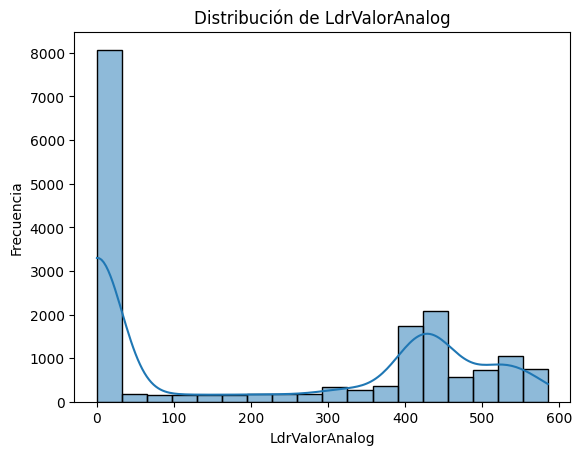

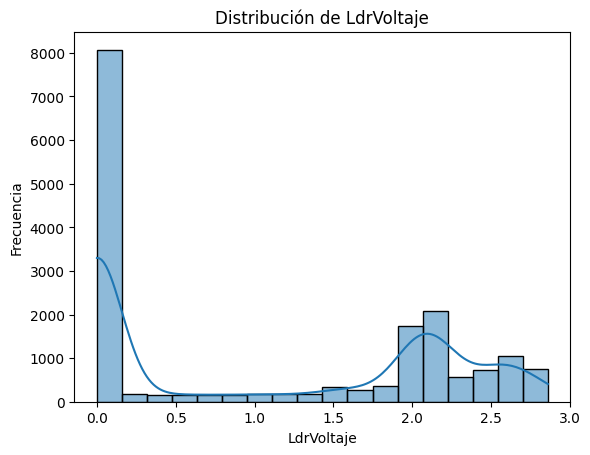

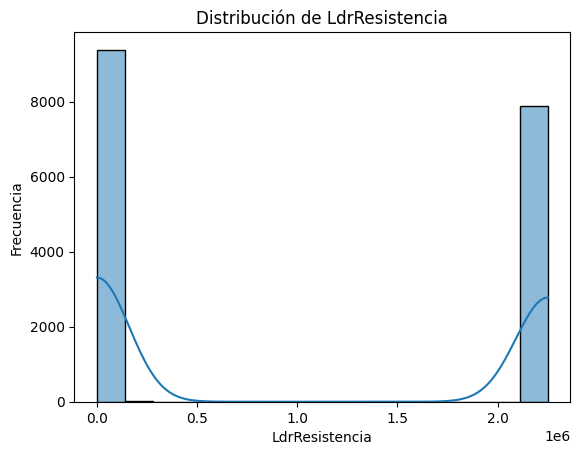

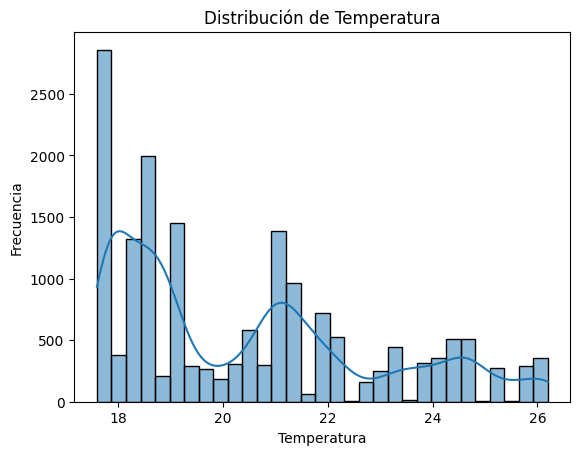

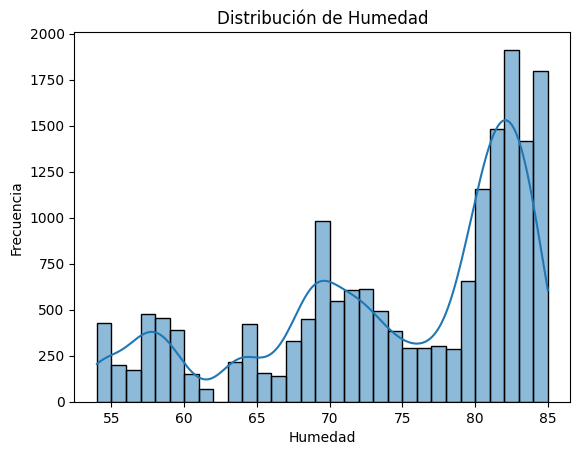

In [7]:
#histogramas de variables numéricas
columnas_numericas = ['LdrValorAnalog', 'LdrVoltaje', 'LdrResistencia', 'Temperatura', 'Humedad']
for col in columnas_numericas:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

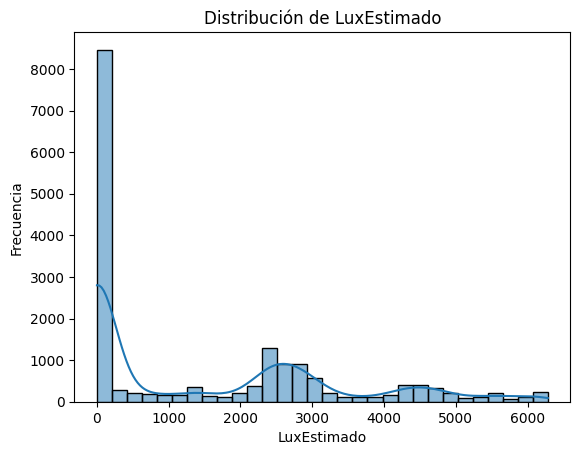

In [8]:
#Cálculo del valor de intensidad lumínica y agregado al dataset
# Calcular estimación de lux con fórmula empírica
# Lux = A * (1000 / R_LDR)^B
A = 500
B = 1.4
df["LuxEstimado"] = A * (1000 / df["LdrResistencia"])**B

#Histograma de la nueva variable
sns.histplot(df['LuxEstimado'], kde=True)
plt.title(f'Distribución de LuxEstimado')
plt.xlabel('LuxEstimado')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
print("Promedio de intensidad lumínica")
print(df['LuxEstimado'].mean())

Promedio de intensidad lumínica
1523.8683414098805


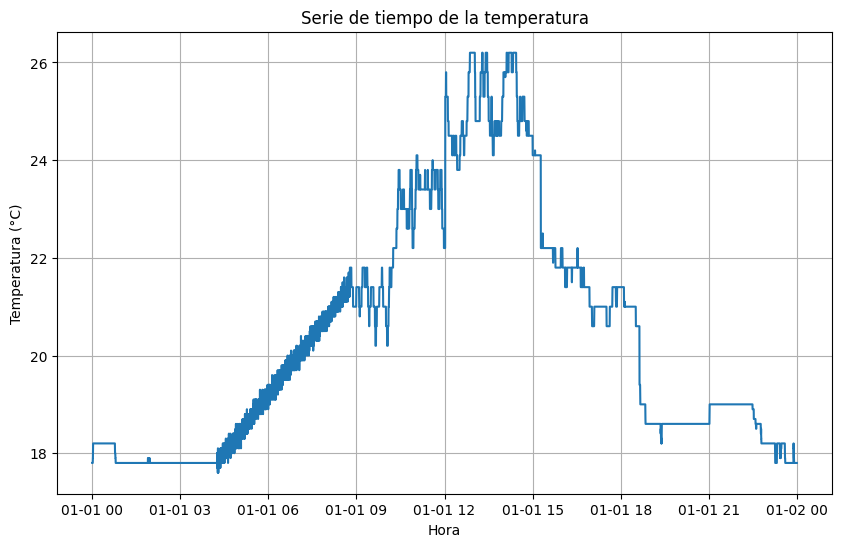

In [10]:
# Crear la gráfica de la serie de tiempo para temperatura
plt.figure(figsize=(10, 6))
plt.plot(df['Hora'], df['Temperatura'])
plt.title('Serie de tiempo de la temperatura')
plt.xlabel('Hora')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.show()

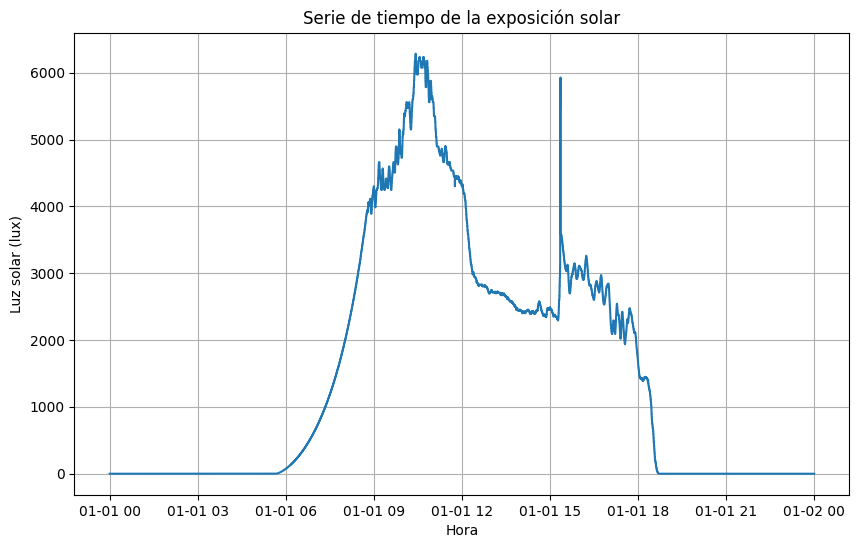

In [11]:
# Crear la gráfica de la serie de tiempo para luz solar
plt.figure(figsize=(10, 6))
plt.plot(df['Hora'], df['LuxEstimado'])
plt.title('Serie de tiempo de la exposición solar')
plt.xlabel('Hora')
plt.ylabel('Luz solar (lux)')
plt.grid(True)
plt.show()